<a href="https://colab.research.google.com/github/rafifrizqullah/MobileNetLSTM-Anomaly-Detection/blob/main/MobileNetLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [ ]:
!pip install keras-layer-normalization

In [ ]:
class Config:
  DATASET_PATH ="/content/drive/My Drive/Colab Notebooks/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  SINGLE_TEST_PATH = "/content/drive/My Drive/Colab Notebooks/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032"
  BATCH_SIZE = 4
  EPOCHS = 3
  MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/model_lstm.hdf5"

In [ ]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips



    

In [ ]:
from keras import backend as K

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_pred.dtype)))

In [ ]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
from keras.models import Sequential, load_model
from keras.losses import SparseCategoricalCrossentropy
from keras_layer_normalization import LayerNormalization
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    # print(training_set)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    # seq.compile(loss='contrastive_loss', optimizer=rms, metrics=[accuracy])
    # seq.compile(optimizer='adam',
    #           loss=SparseCategoricalCrossentropy(from_logits=True),
    #           metrics=['accuracy'])
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [ ]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test


In [ ]:
import matplotlib.pyplot as plt

def evaluate():
    model = get_model(True)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_7 (Layer (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_8 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_9 (Layer (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 10, 32, 32, 32)   

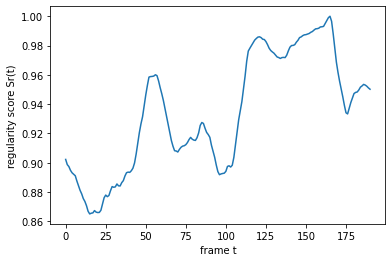

In [ ]:
evaluate()